## 1. Importing the Libraries

In [1]:
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import numpy as np
import sklearn 
import tensorflow as tf
import tensorflow.keras.optimizers as Optimizer
import matplotlib.pyplot as plt
import os

In [2]:
# first connect to mount drive
%cd /content/drive/MyDrive/Projects/IntelImageClassification

/content/drive/MyDrive/Projects/IntelImageClassification


In [3]:
from fetch_dataset import load_traindata, load_valdata, process
from utils import test_prediction, test_data_for_matrix, plot_accuracy, plot_loss

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Prefetch and Tuning in Tensorflow

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

## 3. Data Loading

* You might be using flow_from_directory along with ImageDataGenerator() to set up the dataset, but they aren't compatible with tf.data.AUTOTUNE. Use tf.keras.preprocessing.image_dataset_from_directory instead to load the dataset.

In [5]:
image_size = (299,299)
checkpoint_filepath = 'xception_checkpoint/'

batch_size = 32
train_ds = load_traindata(batch_size, image_size)
val_ds = load_valdata(batch_size, image_size)

train_ds = train_ds.map(process)
val_ds = val_ds.map(process)

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


## 4. Model Architecture and Transfer learning

In [8]:
def create_model(image_size):
    image_shape = image_size + (3,)    

    base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=image_shape)
    base_model.trainable=False

    '''base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet")
    
    inputs = tf.keras.Input(shape=image_shape)
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(6, activation = 'Softmax' )(x)
    model = tf.keras.Model(inputs, outputs)'''

    model = Models.Sequential()
    model.add(base_model)
    model.add(Layers.GlobalAveragePooling2D())
    model.add(Layers.Dropout(0.3))
    model.add(Layers.Dense(6, activation='softmax'))

    return model

model = create_model(image_size)


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 20,873,774
Trainable params: 12,294
Non-trainable params: 20,861,480
_________________________________________________________________


## 5. Model compile and Learning rate Rescheduling

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (0, 0.0001),
    (5, 0.00001),
    (10, 0.000005)
]


def lr_schedule(epoch, lr):
    
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr

lr_scheduler_on_pretrained = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=2)


model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    verbose=2,
    save_best_only=True)

## 6. Model Training

In [23]:
history = model.fit(train_ds,
                    epochs=15,
                    validation_data=val_ds,
                    verbose = 1,
                    callbacks = [lr_scheduler_on_pretrained, model_checkpoint_callback])

Epoch 1/15

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.
439/439 [==============================] - 75s 166ms/step - loss: 0.9839 - accuracy: 0.7489 - val_loss: 0.5754 - val_accuracy: 0.8803

Epoch 00001: val_accuracy improved from -inf to 0.88033, saving model to xception_checkpoint/
Epoch 2/15

Epoch 00002: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
439/439 [==============================] - 70s 159ms/step - loss: 0.4724 - accuracy: 0.8757 - val_loss: 0.3979 - val_accuracy: 0.8943

Epoch 00002: val_accuracy improved from 0.88033 to 0.89433, saving model to xception_checkpoint/
Epoch 3/15

Epoch 00003: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
439/439 [==============================] - 70s 159ms/step - loss: 0.3672 - accuracy: 0.8887 - val_loss: 0.3355 - val_accuracy: 0.8997

Epoch 00003: val_accuracy improved from 0.89433 to 0.89967, saving model to xception_checkpoint/
Epoch 4/15

Epoch 00004: LearningRate

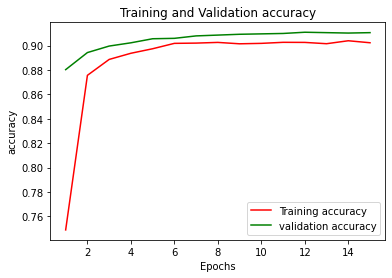

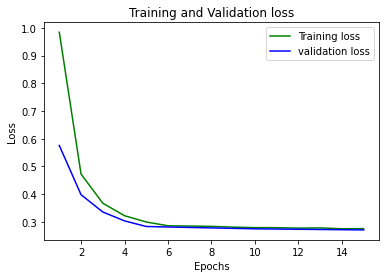

In [24]:
plot_accuracy(history.history['accuracy'], history.history['val_accuracy'])
plot_loss(history.history['loss'], history.history['val_loss'])

In [6]:
test_img, test_label = test_data_for_matrix(val_ds)

In [11]:
model.load_weights(checkpoint_filepath)

In [12]:
confusion,report = test_prediction(model, test_img, test_label)

In [13]:
print(confusion)

[[390   0   0   1   5  41]
 [  0 471   1   1   1   0]
 [  1   2 454  76  18   2]
 [  0   1  68 447   7   2]
 [  0   0   3   1 505   1]
 [ 33   0   0   1   1 466]]


In [19]:
print(report)

              precision    recall  f1-score   support

           0      0.920     0.892     0.906       437
           1      0.994     0.994     0.994       474
           2      0.863     0.821     0.842       553
           3      0.848     0.851     0.850       525
           4      0.940     0.990     0.965       510
           5      0.910     0.930     0.920       501

    accuracy                          0.911      3000
   macro avg      0.913     0.913     0.913      3000
weighted avg      0.910     0.911     0.910      3000



In [62]:
from glob import glob
from pathlib import Path

In [69]:
pred_dir =  Path('/content/drive/MyDrive/Kaggle/seg_pred/seg_pred')

In [70]:
pred_img = list(pred_dir.glob('*.jpg'))

In [71]:
import cv2
def process_pred_images(image_path):
    image = cv2.imread(str(image_path))
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB )
    return rgb_image

In [ ]:
np.array(list(map(process_pred_images, pred_img )))

KeyboardInterrupt: ignored

In [50]:
cv2.imread(pred_img[0].resolve())

SystemError: ignored

In [67]:
str(pred_img[0])

'/content/drive/MyDrive/Kaggle/seg_pred/seg_pred/9963.jpg'